In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For google drive - location of data
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Sea/data')

Mounted at /content/drive


In [3]:
#Loading Data

X  = pd.read_csv('training_input_ssta.csv',header=None)
Y  = pd.read_csv('training_output.csv',header=None)
Z  = pd.read_csv('test_input_ssta_phase_two.csv',header=None)
All = pd.read_csv('ssta_1940_2023.csv',header=None)


C  = pd.read_csv('coords.csv',header=None)
C  = C.T.reset_index()

C.columns = range(3)

In [4]:
#Build features  main (location under study) + min,max and mean of 8 closest
def minmax(df):
  out=pd.DataFrame()
  for i in range(12):
    rows= np.array([0,1,2,3,5,6,7,8])+i*9
    out['main_'+str(i)] = df[i*9+4]
    out['mean_'+str(i)] = df[rows].mean(axis=1)
    out['max_'+str(i)]  = df[rows].max(axis=1)
    out['min_'+str(i)]  = df[rows].min(axis=1)
  return out

In [5]:
#Mapping values to the new structure
def MapValues(X,LRUD):
  shape=X.shape
  B=np.zeros((shape[0],shape[1],9))+np.nan
  for i in range(len(X)):
    A=LRUD*0
    for c in LRUD.columns:
      A[c] = LRUD[c].map(X.loc[i].T)
    B[i]=A.values
  return B

In [6]:
# global map dataframe
df = pd.DataFrame(columns=C[1].unique(),index=C[2].unique())
for  c in df.columns:
    df[c]=C.loc[C[1]==c].set_index(2)[0].astype(int)

In [7]:
# New DataFrame:  location under study + 8 neighboring locations per row
LRUD=pd.DataFrame(index=df.values.flatten())
for i in range(-1,2):
  for j in range(-1,2):
     LRUD['C'+str(i)+'_'+str(j)]=np.nan

     LRUD['C'+str(i)+'_'+str(j)] = df.shift(-i,axis=1).shift(-j,axis=0).values.flatten()
LRUD=LRUD.loc[X.columns]


In [8]:
#Apply the mappings
B    = MapValues(X,LRUD)
Bz   = MapValues(Z,LRUD)
Ball = MapValues(All,LRUD)

In [9]:
#  concatenating 12 months per row - Training set
Xin= pd.DataFrame()
Yin=pd.DataFrame()
for i in range(12):
      for j in range(9):
        Xin[i+j*12]=B[-120:][i:i-12,:,j].flatten()

Yin= Y[-120:].values[i:i-12,:].flatten()
Xin.columns=list(range(108))

<ipython-input-9-d4b36126f3a7>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xin[i+j*12]=B[-120:][i:i-12,:,j].flatten()


In [10]:
#  concatenating 12 months per row - Test set
Xout= pd.DataFrame()
for i in range(0,12):
      for j in range(9):

        Xout[i-12 +j*12]=Bz[i::12,:,j].flatten()

Xout.columns=list(range(108))

<ipython-input-10-3c8e3403cf25>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xout[i-12 +j*12]=Bz[i::12,:,j].flatten()


In [58]:
#  concatenating 12 months per row - All
Xall= pd.DataFrame()
for i in range(0,12):
      for j in range(9):
        Xall[i-12 +j*12]=Ball[i:i-12,:,j].flatten()
Xall.columns=list(range(108))

<ipython-input-58-6615a00a2281>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xall[i-12 +j*12]=Ball[i:i-12,:,j].flatten()


In [61]:
#  final input stracture
Xin=minmax(Xin)
Xout=minmax(Xout)
Xall=minmax(Xall)

In [13]:
# size per year
year=int(len(Xin)/9)

In [14]:
# Training Bayesian Ridge Models
from sklearn import linear_model
reg3 = linear_model.BayesianRidge()
reg9 = linear_model.BayesianRidge()

reg3.fit(Xin.fillna(0)[-year*3:].values, Yin[-year*3:])
reg9.fit(Xin.fillna(0)[-year*9:].values, Yin[-year*9:])

BayesianRidge()

In [15]:
# Train season detection model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,GaussianNoise,Layer
from tensorflow.keras.optimizers import Adam


TempTrain  =  pd.read_csv('training_input_sst.csv',header=None)
TempTest   =  pd.read_csv('test_input_sst_phase_two.csv',header=None)




TempTrain = TempTrain.add(-TempTrain.mean(axis=1),axis=0).div(TempTrain.std(axis=1),axis=0)
Season    = TempTrain.index%12
Season    = Season.values

TempTest  = TempTest.add(-TempTest.mean(axis=1),axis=0).div(TempTest.std(axis=1),axis=0)



Ttrain,Tytrain = TempTrain[:-132],Season[:-132]
Tval,Tyval     = TempTrain[-120:],Season[-120:]



# Define the autoencoder model
input_dim    = Ttrain.shape[1]  # Example for MNIST dataset, modify accordingly
encoding_dim = 512  # Size of encoded representation

input_layer  = Input(shape=(input_dim,))

x            = GaussianNoise(0.01)(input_layer)
x            = Dense(512, activation='relu')(x)
x            = Dense(12, activation='softmax')(x)
out          = x

month_model  = Model(input_layer, out)

# Compile the model
month_model.compile(optimizer=Adam(0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['Accuracy'])

month_model.fit(Ttrain.fillna(0),Tytrain,
                epochs=100,
                batch_size = 32,
                validation_data=(Tval.fillna(0),Tyval))

Epoch 1/100
23/23 [==============================] - 1s 21ms/step - loss: 2.3610 - Accuracy: 0.1855 - val_loss: 2.1163 - val_Accuracy: 0.1917
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 2.0373 - Accuracy: 0.3138 - val_loss: 1.9332 - val_Accuracy: 0.3833
Epoch 3/100
23/23 [==============================] - 0s 13ms/step - loss: 1.8941 - Accuracy: 0.3598 - val_loss: 1.8104 - val_Accuracy: 0.5167
Epoch 4/100
23/23 [==============================] - 0s 13ms/step - loss: 1.7895 - Accuracy: 0.4505 - val_loss: 1.7383 - val_Accuracy: 0.3833
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 1.7119 - Accuracy: 0.5035 - val_loss: 1.6686 - val_Accuracy: 0.5917
Epoch 6/100
23/23 [==============================] - 0s 13ms/step - loss: 1.6547 - Accuracy: 0.4951 - val_loss: 1.6176 - val_Accuracy: 0.5250
Epoch 7/100
23/23 [==============================] - 0s 13ms/step - loss: 1.5887 - Accuracy: 0.5481 - val_loss: 1.5637 - val_Accuracy: 0.5500
Epoch 

In [16]:
Season_out = month_model.predict(TempTest.fillna(0))
Season_out= pd.DataFrame(Season_out).round(2).idxmax(axis=1)
Season_out= (Season_out[11::12]+3)%12

27/27 [==============================] - 0s 3ms/step


In [17]:
Cl=X[-120:]
Cl['Season']=Tyval

<ipython-input-17-a07aa20c74ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cl['Season']=Tyval


In [18]:
Clocal  = Cl.groupby('Season').mean().loc[Season_out]
Clocal.index =range(71)
Cglobal = 0.1

In [19]:
predictions =   0.5*(reg3.predict(Xout.fillna(0).values) + reg9.predict(Xout.fillna(0).values)).reshape(Clocal.values.shape)  + 0.5*(Clocal+Cglobal)

In [20]:
# Predictions for phase 2

predictions

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.246650,0.285163,0.394630,0.412914,0.344380,0.281165,0.249189,0.241977,0.217309,0.180520,...,0.490963,0.435735,0.526887,0.584543,0.644101,0.758485,0.729441,0.585038,0.599561,0.280780
1,0.126434,0.200934,0.227742,0.124109,0.120664,0.155485,0.202582,0.258353,0.229812,0.203792,...,0.370743,0.363373,0.441361,0.487747,0.382396,0.391025,0.584080,0.607520,0.815705,0.900897
2,-0.032314,-0.097862,-0.042445,-0.114527,-0.060713,-0.068216,-0.059725,-0.015311,0.016974,0.010308,...,0.599404,0.622478,0.701509,0.664108,0.600625,0.613223,0.663151,0.667306,0.772543,0.497383
3,-0.280591,-0.338253,-0.347124,-0.340219,-0.276969,-0.226868,-0.198354,-0.214103,-0.215504,-0.171423,...,0.623571,0.599519,0.596119,0.580316,0.520774,0.456766,0.532503,0.520761,0.646853,0.677473
4,-0.108468,-0.072621,-0.045480,0.050302,0.114757,0.141238,0.140413,0.154004,0.150237,0.141896,...,0.231962,0.170279,0.233635,0.289393,0.296186,0.381232,0.506409,0.545174,0.792649,0.641996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.705800,0.630022,0.616478,0.624025,0.595418,0.477989,0.453142,0.466263,0.427875,0.367342,...,0.707945,0.763345,0.754505,0.747986,0.750889,0.826391,0.975401,1.060311,1.189304,0.795673
67,0.013628,0.075668,0.144911,0.124729,0.164645,0.161304,0.187654,0.246700,0.231317,0.184422,...,0.408346,0.395159,0.466816,0.518768,0.471058,0.474398,0.633531,0.683099,0.805427,0.906907
68,-0.199731,-0.189963,-0.163192,-0.121498,-0.031970,-0.001630,0.047164,0.130547,0.164482,0.136897,...,0.444819,0.425535,0.442224,0.412148,0.351325,0.365253,0.413967,0.319104,0.452174,0.579302
69,-0.295151,-0.354138,-0.387700,-0.545412,-0.513441,-0.506210,-0.486607,-0.456958,-0.495007,-0.495999,...,0.424919,0.449060,0.507834,0.544935,0.483250,0.473051,0.559216,0.509262,0.534748,0.336227


Post Competition - Full Data

In [102]:
Clocal  = Cl.groupby('Season').mean().loc[(All.index+3)%12][12:]
Clocal.index =range(len(Clocal))
Cglobal = 0.1

All_pred  =   0.5*(reg3.predict(Xall.fillna(0).values) + reg9.predict(Xall.fillna(0).values)).reshape(Clocal.values.shape)  + 0.5*(Clocal+Cglobal)
Base_pred =   0.5*(reg3.predict(Xall.fillna(0).values) + reg9.predict(Xall.fillna(0).values)).reshape(Clocal.values.shape)


In [103]:
FinalTest=  All_pred[:-3]
FinalBaseTest=  Base_pred[:-3]

Yall =All[12+3:]
Cons =All[12:-3]
Yall.index=FinalTest.index
Cons.index=FinalTest.index

In [107]:
Error_model=np.square(FinalTest-Yall)
Error_base=np.square(FinalBaseTest-Yall)

Error_cons =np.square(Cons-Yall)


In [116]:
import seaborn as sns
sns.set_theme(style="darkgrid")



In [126]:
R1 = np.sqrt( Error_model.mean(axis=1).rolling(12).mean()[::12])
R2 = np.sqrt( Error_base.mean(axis=1).rolling(12).mean()[::12])

R0 = np.sqrt(Error_cons.mean(axis=1).rolling(12).mean()[::12])

R0.index=list(range(1941,1941+83))

R1.index=list(range(1941,1941+83))
R2.index=list(range(1941,1941+83))

2010    0.591162
2011    0.682578
2012    0.601412
2013    0.569387
2014    0.566890
2015    0.584236
2016    0.651155
2017    0.612497
2018    0.577871
2019    0.597611
2020    0.623241
2021    0.623537
2022    0.618326
2023    0.668794
dtype: float64

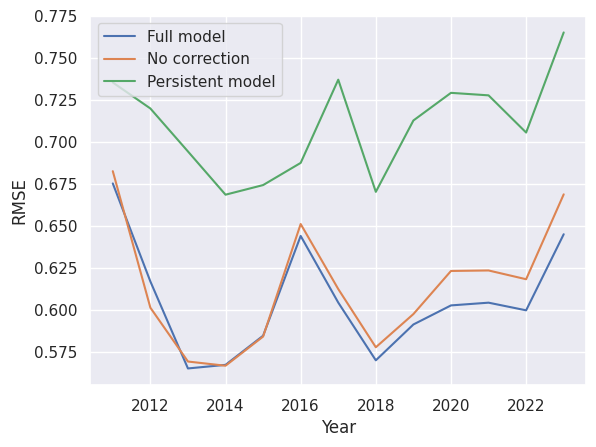

In [133]:
plt.plot(R1[-13:], label='Full model')
plt.plot(R2[-13:], label='No correction')
plt.plot(R0[-13:], label='Persistent model')
plt.ylabel('RMSE')
plt.xlabel('Year')
plt.legend()

plt.show()

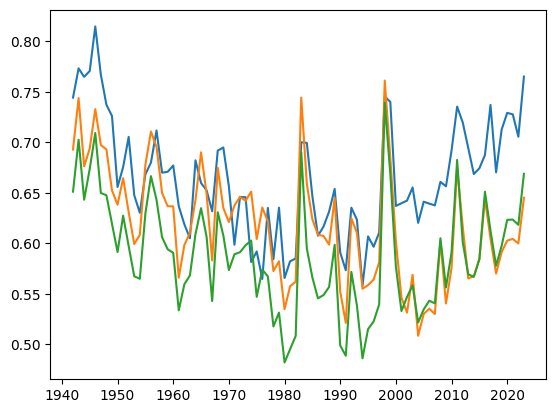

In [113]:
plt.plot(R0)

plt.plot(R1)
plt.plot(R2)


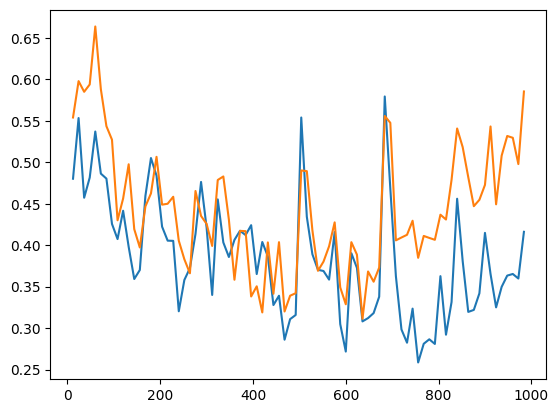

In [90]:
plt.plot( Error_model.mean(axis=1).rolling(12).mean()[::12])
plt.plot( Error_cons.mean(axis=1).rolling(12).mean()[::12])